## Network Analysis

In this notebook we will explore some particular features of the network. 

For example:
- How do relationships look like between members?
- Does every twitter profile post tweets, or do some profiles only receive tweets?
- Do members own multiple profiles?

In [1]:
# import dependencies
import pandas as pd
import numpy as np
import nltk
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# load dataset as pandas dataframe
df = pd.read_csv('Twitter_ISIS_data/how-isis-uses-twitter/tweets.csv')

In [2]:
# create list of stopwords for topic analysis
from nltk.corpus import stopwords

english_stopwords = list(set(stopwords.words('english')))
french_stopwords = list(set(stopwords.words('french')))
turkish_stopwords = list(set(stopwords.words('turkish')))

stopwords = english_stopwords + french_stopwords + turkish_stopwords

In [4]:
def get_topic_relevancy_per_message(list_of_document_index_and_message, no_features=1000, no_topics=4, stop_words=stopwords): # include parameters in function (no_features, no_topics)

    document_index = [row[0] for row in list_of_document_index_and_message]
    documents = [row[1] for row in list_of_document_index_and_message]

    # get term counts 
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words=stopwords)
    tf = tf_vectorizer.fit_transform(documents)
    tf_feature_names = tf_vectorizer.get_feature_names()

    # convert to arrays
    tf_array = tf_vectorizer.fit_transform(documents).toarray()
    tf_feature_names_array = np.array(tf_vectorizer.get_feature_names())

    # run model
    lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
    doctopic = lda.fit_transform(tf_array)

    # scale the document-component matrix such that the component values associated with each document sum to one
    doctopic = doctopic / np.sum(doctopic, axis=1, keepdims=True)

    # give each document a name (name of the index) 
    # and convert the name of each document to an array
    documents_names = np.asarray(document_index)
    doctopic_orig = doctopic.copy()

    # create a matrix that returns the relevance of a topic per document
    num_groups = len(set(documents_names))
    doctopic_grouped = np.zeros((num_groups, no_topics))
    for i, name in enumerate(sorted(set(documents_names))):
        doctopic_grouped[i, :] = np.mean(doctopic[documents_names == name, :], axis=0)

    # get the importantance of each topic per document
    doctopic = doctopic_grouped


    # print documents
    # print display_topics(nmf, tfidf_feature_names, no_top_words) 
    # print doctopic

    return doctopic


def return_document_and_most_important_topic_and_value(list_of_document_index_and_message, no_features=1000, no_topics=4):
    
    doctopic = get_topic_relevancy_per_message(list_of_document_index_and_message, no_features=no_features, no_topics=no_topics) 

    document_index = [row[0] for row in list_of_document_index_and_message]
    documents = [row[0] for row in list_of_document_index_and_message]
    
    # give each document a name (name of the index) 
    # and convert the name of each document to an array

    doctopic_list = doctopic.tolist()
    documents_names = np.asarray(document_index)
    documents_names_list = documents_names.tolist()

    documents_names_doctopics = zip(documents_names_list, doctopic_list)
    
    # create dataframe of array with topic names as column names
    column_names = range(len(doctopic[0]))
    topic_names = ["topic" + str(i) for i in column_names]

    df = pd.DataFrame(doctopic, index=documents_names, columns=topic_names)

    # return max value for each row
    # convert column to list
    max_value = df.max(axis=1).tolist()

    # create new column that states the topic that is most important for the document 
    # convert column to list
    topic = df.idxmax(axis=1).tolist()

    # create list of most important topic and highest value per document
    document_topic_value = zip(documents_names, topic, max_value)

    return document_topic_value


def return_messages_with_clear_topic(list_of_document_index_and_message, no_features=1000, no_topics=4, threshold=0):
    """return documents where topic relevancy is > a certain level"""
    document_topic_value = return_document_and_most_important_topic_and_value(list_of_document_index_and_message, no_features=no_features, no_topics=no_topics)
    
    df = pd.DataFrame(document_topic_value, columns = ['documents_names', 'topic', 'max_value'])

    # keep only the rows where value > threshold
    df_relevant = df[df['max_value'] > threshold]

    # convert this dataframe to a list
    relevant_doctopics = df_relevant.values.tolist()

    return relevant_doctopics


def return_topwords_topdocuments_per_topic(list_of_document_index_and_message, no_topics=0, no_top_words=0, no_top_documents=0, ): 
    
    documents = [row[1] for row in list_of_document_index_and_message]
    
    # import modules
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.decomposition import LatentDirichletAllocation
    import numpy as np

    # prepare data for model
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=0.01, stop_words=stopwords)
    tf = tf_vectorizer.fit_transform(documents)
    tf_feature_names = tf_vectorizer.get_feature_names()

    lda_model = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
    lda_W = lda_model.transform(tf)
    lda_H = lda_model.components_

    def display_topwords_topdocuments_per_topic(H, W, feature_names, documents, no_top_words, no_top_documents):
        for topic_idx, topic in enumerate(H):
            print "Topic %d:" % (topic_idx)
            print " ".join([feature_names[i]
                            for i in topic.argsort()[:-no_top_words - 1:-1]])
            top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
            for doc_index in top_doc_indices:
                print documents[doc_index]
    
    return display_topwords_topdocuments_per_topic(lda_H, lda_W, tf_feature_names, documents, no_top_words, no_top_documents)

In [5]:
def topic_analysis(df):

    # remove urls from tweets
    df['tweets'] = df['tweets'].apply(lambda x: re.sub(r'http\S+', '', x))

    # create new column for tokenized tweets that returns @taggedprofile and #hashtags as one token 
    tweettknzer = TweetTokenizer()

    df['tokenized_tweets'] = df['tweets'].apply(lambda x: tweettknzer.tokenize(x))

    # create a list of tuples of tweets and index of tweet
    # add index name to dataframe
    df = df.reset_index()

    tweets = df['tweets'].tolist()
    index = df['index'].values.tolist()
    tweets_index = zip(index, tweets)

    # return list of indes, tweet topic, and topic score
    document_topic_value = return_document_and_most_important_topic_and_value(tweets_index, no_topics=4)

    # add topic to df with tweets
    row_topic = [(row[0], row[1]) for row in document_topic_value]

    # convert list of tuples to dataframe
    df_tweet_topic = pd.DataFrame(row_topic, columns=['index', 'topic'])

    # merge df_tweet_topic with df
    df = df.merge(df_tweet_topic, on='index', how='left')

    return df

In [6]:
%%time
df = topic_analysis(df)

CPU times: user 48.2 s, sys: 538 ms, total: 48.8 s
Wall time: 49.3 s


In [7]:
df

,index,name,username,description,location,followers,numberstatuses,time,tweets,tokenized_tweets,topic
0,0,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:07,ENGLISH TRANSLATION: 'A MESSAGE TO THE TRUTHFU...,"[ENGLISH, TRANSLATION, :, ', A, MESSAGE, TO, T...",topic0
1,1,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:27,ENGLISH TRANSLATION: SHEIKH FATIH AL JAWLANI '...,"[ENGLISH, TRANSLATION, :, SHEIKH, FATIH, AL, J...",topic0
2,2,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:29,ENGLISH TRANSLATION: FIRST AUDIO MEETING WITH ...,"[ENGLISH, TRANSLATION, :, FIRST, AUDIO, MEETIN...",topic0
3,3,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:37,ENGLISH TRANSLATION: SHEIKH NASIR AL WUHAYSHI ...,"[ENGLISH, TRANSLATION, :, SHEIKH, NASIR, AL, W...",topic2
4,4,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:45,ENGLISH TRANSLATION: AQAP: 'RESPONSE TO SHEIKH...,"[ENGLISH, TRANSLATION, :, AQAP, :, ', RESPONSE...",topic0
5,5,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:51,THE SECOND CLIP IN A DA'WAH SERIES BY A SOLDIE...,"[THE, SECOND, CLIP, IN, A, DA'WAH, SERIES, BY,...",topic1
6,6,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 22:04,ENGLISH TRANSCRIPT : OH MURABIT! :,"[ENGLISH, TRANSCRIPT, :, OH, MURABIT, !, :]",topic0
7,7,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 22:06,ENGLISH TRANSLATION: 'A COLLECTION OF THE WORD...,"[ENGLISH, TRANSLATION, :, ', A, COLLECTION, OF...",topic2
8,8,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 22:17,Aslm Please share our new account after the pr...,"[Aslm, Please, share, our, new, account, after...",topic2
9,9,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/10/2015 0:05,ENGLISH TRANSLATION: AQAP STATEMENT REGARDING ...,"[ENGLISH, TRANSLATION, :, AQAP, STATEMENT, REG...",topic2


### Create connections from users and tagged profiles

In [8]:
# create new column that returns only the tokens that refer to a tagged profile
df['tagged_profiles'] = df['tokenized_tweets'].map(lambda x: [token for token in x if token.startswith('@')])

In [9]:
# remove @ character from tagged profiles
df['tagged_profiles'] = df['tagged_profiles'].apply(lambda x: [token.replace('@','') for token in x])

In [10]:
# keep only the tweets that contain a tagged profile
df = df[df.astype(str)['tagged_profiles'] != '[]']

In [11]:
df

,index,name,username,description,location,followers,numberstatuses,time,tweets,tokenized_tweets,topic,tagged_profiles
8,8,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 22:17,Aslm Please share our new account after the pr...,"[Aslm, Please, share, our, new, account, after...",topic2,"[KhalidMaghrebi, seifulmaslul123, CheerLeadUni..."
10,10,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/10/2015 0:08,@KhalidMaghrebi @seifulmaslul123 @CheerLeadUni...,"[@KhalidMaghrebi, @seifulmaslul123, @CheerLead...",topic0,"[KhalidMaghrebi, seifulmaslul123, CheerLeadUni..."
14,14,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2/9/2015 10:54,@IbnNabih1 @MuwMedia @Dawlat_islam7 Not transl...,"[@IbnNabih1, @MuwMedia, @Dawlat_islam7, Not, t...",topic0,"[IbnNabih1, MuwMedia, Dawlat_islam7]"
15,15,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2/12/2015 13:03,"Aslm, anybody translating the new JN video? Wi...","[Aslm, ,, anybody, translating, the, new, JN, ...",topic1,"[IbnNabih1, KhalidMaghrebi_, MuwMedia, Polder_..."
16,16,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2/12/2015 13:11,@IbnNabih1 @KhalidMaghrebi_ @MuwMedia @Polder_...,"[@IbnNabih1, @KhalidMaghrebi_, @MuwMedia, @Pol...",topic2,"[IbnNabih1, KhalidMaghrebi_, MuwMedia, Polder_..."
17,17,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2/16/2015 15:57,@IbnNabih1 @abuw_ukasyah @polder_mujaahid @Abu...,"[@IbnNabih1, @abuw_ukasyah, @polder_mujaahid, ...",topic0,"[IbnNabih1, abuw_ukasyah, polder_mujaahid, Abu..."
18,18,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2/20/2015 16:28,@AbdirahmanBash2 @KhalidMaghrebi_ @IbnNabih1 @...,"[@AbdirahmanBash2, @KhalidMaghrebi_, @IbnNabih...",topic0,"[AbdirahmanBash2, KhalidMaghrebi_, IbnNabih1, ..."
19,19,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2/20/2015 16:29,@AbdirahmanBash2 @KhalidMaghrebi_ @IbnNabih1 @...,"[@AbdirahmanBash2, @KhalidMaghrebi_, @IbnNabih...",topic0,"[AbdirahmanBash2, KhalidMaghrebi_, IbnNabih1, ..."
20,20,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2/20/2015 16:30,@AbdirahmanBash2 @KhalidMaghrebi_ @IbnNabih1 @...,"[@AbdirahmanBash2, @KhalidMaghrebi_, @IbnNabih...",topic0,"[AbdirahmanBash2, KhalidMaghrebi_, IbnNabih1, ..."
23,23,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2/28/2015 23:35,Video by @ansardeenfront with Eng Subtitles: '...,"[Video, by, @ansardeenfront, with, Eng, Subtit...",topic1,"[ansardeenfront, a8531]"


In [12]:
# retrieve list of unique tagged profiles
tagged_profiles = list(set([pair for row in df['tagged_profiles'] for pair in row]))
tagged_profiles[:5]

[u'', u'Jazrawi_3uud', u'5629haqq', u'VSOForever', u'AsebAlRasWenak']

In [13]:
# retrieve list of unique usernames
usernames = list(df['username'].unique())
usernames[:5]

['GunsandCoffee70',
 'YazeedDhardaa25',
 'BaqiyaIs',
 'abubakerdimshqi',
 'WhiteCat_7']

In [14]:
# get number of unique tagged profiles and unique usernames
print '# unique tagged profiles: ', len(tagged_profiles)
print '# unique usernames: ', len(usernames)

# unique tagged profiles:  3296
# unique usernames:  107


In [15]:
# check on passive accounts
print 'Jazrawi_3uud' in tagged_profiles
print 'Jazrawi_3uud' in usernames

True
False


This shows that some Twitter users are tagged, but don't post tweets themselves.

This could imply that those users that are tagged, but don't post tweets themselves, refer to passive accounts.
Where I define a passive account as an account that only receives tweets.

In [37]:
len([account for account in tagged_profiles if account in usernames])

77

77 profiles out of 3301 profiles are members that both post a tweet as well as get tagged by other members.

In [38]:
len([account for account in tagged_profiles if account not in usernames])

3219

This implies indeed that 3224 profiles are passive accounts.

Store both the profiles of active accounts and passive accounts in a separate list. 

We may want to explore the network in its entirety and with only the active accounts.

In [16]:
active_accounts = [account for account in tagged_profiles if account in usernames]
passive_accounts = [account for account in tagged_profiles if account not in usernames]

### Prepare data for network analysis

#### Create a list of connections as a pair of tuples

Output should look like this:
    
    [(username, tagged_profile1), (username, tagged_profile2), (username, tagged_profile3)]

In [36]:
pd.set_option('display.max_colwidth', -1)

In [42]:
# create a dataframe that only stores the username and tagged profiles
df_connections = df[['username', 'tagged_profiles']]
print len(df_connections)
df_connections.head()

9878


,username,tagged_profiles
8,GunsandCoffee70,"[KhalidMaghrebi, seifulmaslul123, CheerLeadUni..."
10,GunsandCoffee70,"[KhalidMaghrebi, seifulmaslul123, CheerLeadUni..."
14,GunsandCoffee70,"[IbnNabih1, MuwMedia, Dawlat_islam7]"
15,GunsandCoffee70,"[IbnNabih1, KhalidMaghrebi_, MuwMedia, Polder_..."
16,GunsandCoffee70,"[IbnNabih1, KhalidMaghrebi_, MuwMedia, Polder_..."


In [43]:
# convert dataframe to dictionary
connections_dict = df_connections.set_index('username').T.to_dict(orient='list')
print len(connections_dict.keys())

107


/Users/annalie/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:882: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  "columns will be omitted.", UserWarning)


In [25]:
# create the edges (connections) of the graph

# convert the connections dictionary to a list of tuples where each key corresponds to its value in the dictionary
def get_connections(dictionary_with_list_of_values):
    connections = []
    for user,value in dictionary_with_list_of_values.iteritems():
        for item in value:
            for profile in item:
                connections.append((user, profile))
    return connections

In [45]:
edges = get_connections(connections_dict)
print len(edges)
print edges[:5]

150
[('murasil1', u'AP'), ('Suspend_Me_fags', u'Sadk_Monasr51'), ('MhzBnt', u'2bnalquds12'), ('Uncle_SamCoco', u'RomainCaillet'), ('Uncle_SamCoco', u'_DavidThomson')]


### Network analysis

In [17]:
import networkx as nx

#### Create two versions of the graphs

Since a tweet that contains a tagged profile has a direction from the user to the tagged profile we are able to create both an undirected as well as a directed graph.

In [47]:
# create an undirected graph
graph = nx.Graph()

# create a directed graph
d_graph = nx.DiGraph()

In [48]:
# add edges to graph
graph.add_edges_from(edges)

# add edges to directed graph
d_graph.add_edges_from(edges)

In [49]:
print "# of profiles: ", graph.number_of_nodes()
print "# of connections: ", graph.number_of_edges()

# of profiles:  222
# of connections:  145


This shows that there are more profiles than connections. 

Which could imply that some users tweet to their own account.

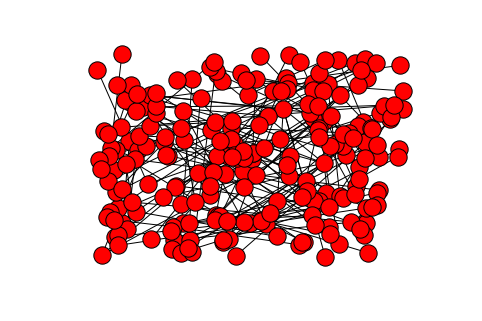

In [57]:
# ways of drawing the graph

# nx.draw(graph)
nx.draw_random(graph)
# nx.draw_circular(graph)
# nx.draw_spectral(graph)
plt.show()

### Community Detection

The criteria for finding good communities is similar to that for finding good clusters. We want to maximize intra-community edges while minimizing inter-community edges. Formally, the algorithm tries to maximize the modularity of network, or the fraction of edges that fall within the community minus the expected fraction of edges if the edges were distributed by random. Good communities should have a high number of intra-community edges, so by maximizing the modularity, we detect dense communities that have a high fraction of intra-community edges.

*Source:* https://blog.dominodatalab.com/social-network-analysis-with-networkx/

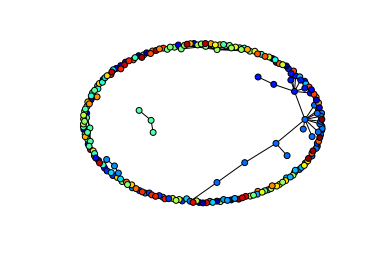

In [72]:
import networkx as nx
import matplotlib.pyplot as plt
import community
 
def detectCommunities(G):
 
    parts = community.best_partition(G)
    values = [parts.get(node) for node in G.nodes()]

    plt.axis("off")
    nx.draw_networkx(G, cmap = plt.get_cmap("jet"), node_color = values, node_size = 35, with_labels = False)
    plt.show()
    
detectCommunities(graph)

### Analyse density of graph and number of connections per user

#### Analyse density of graph

In [96]:
degree = nx.degree(graph)
print '# of profiles with connections in undirected graph: ', len(degree.keys())
print degree

# of profiles with connections in undirected graph:  222
{'murasil1': 1, 'Suspend_Me_fags': 1, 'MhzBnt': 1, u'mkmjnnj': 1, 'Uncle_SamCoco': 2, u'00Rebel_Umm': 1, 'maisaraghereeb': 1, u'wwayyf44rer': 1, u'kingemirb': 1, 'mobi_ayubi': 1, u'HAMZA35209826': 1, 'Witness_alHaqq': 1, 'ismailmahsud': 1, 'ks48a174031': 1, 'MaghrebiQ': 1, u'k1nt_is': 1, u'DMIS_1U': 1, u'MuslimPrisoners': 1, 'Afriqqiya_252': 3, u'28Abu2H': 1, 'wayf44rerr': 1, u'ShamiRebel': 1, u'_DavidThomson': 1, u'RamiAlLolah': 8, 'freelance_112': 2, 'Nidalgazaui': 2, u'parvezicrimes': 1, 'ro34th': 1, u'SadiqKhan': 1, 'MilkSheikh2': 2, u'Islamic_Station': 1, '_IshfaqAhmad': 1, u'DanDuva1': 1, u'8': 1, u'asadanbari6': 1, u'whoamidude': 1, u'htrddjt': 1, 'Fidaee_Fulaani': 2, u'Abu189Haleema': 1, u'NorthernStork': 1, 'WhiteCat_7': 2, 'squadsquaaaaad': 1, u'___TNT___': 1, '04_8_1437': 1, 'abuhanzalah10': 1, 'sonofshishan': 1, u'khalidi_4_sham': 1, 'melvynlion': 1, u'almuwmed': 1, u'uhhgyfergbnj': 1, '432Mryam': 1, 'Jazrawi_Joulan':

In [98]:
degree_d_graph = nx.degree(d_graph)
print '# of profiles with connections in directed graph: ', len(degree_d_graph.keys())

# of profiles with connections in directed graph:  222


In [99]:
print 'density undirected graph: ', nx.density(graph)

density undirected graph:  0.00591088826383


This seems like a very low density. Which means that there are possibly many profiles that have only one connection

In [104]:
# show proportion of ingoig edges per profile
ingoing_edges = nx.in_degree_centrality(d_graph)
print 'ingoing edges per node: '
print ingoing_edges.values()[:20]

ingoing edges per node: 
[0.0, 0.0, 0.0, 0.004524886877828055, 0.0, 0.004524886877828055, 0.0, 0.004524886877828055, 0.004524886877828055, 0.0, 0.004524886877828055, 0.0, 0.0, 0.0, 0.0, 0.004524886877828055, 0.004524886877828055, 0.004524886877828055, 0.004524886877828055, 0.004524886877828055]


In [106]:
# return only those profiles that show a high proportion of the ingoing edges
{k:v for (k,v) in ingoing_edges.items() if v > 0.05}

{}

#### Analyse the number of occurences per connection

In [107]:
from collections import Counter
occurences_per_connection = Counter(edges)
occurences_per_connection

Counter({('04_8_1437', u'uhhgyfergbnj'): 1,
         ('06230550_IS', u'F4Sham'): 1,
         ('1515Ummah', u'wayf44rer__'): 1,
         ('432Mryam', u'iislamic82'): 1,
         ('ALK___226', u'___TNT___'): 1,
         ('AbdusMujahid149', u'LibyaAlHurraTV'): 1,
         ('AbuLaythAlHindi', u'adnan04ar01'): 1,
         ('AbuMusab_110', u'SadiqKhan'): 1,
         ('AbuMusab_110', u'ambrablu'): 1,
         ('AbuNaseeha_03', u'mkmjnnj'): 1,
         ('Abu_Azzzam25', u'green_lemonnn'): 1,
         ('Abu_Ibn_Taha', u'jisrtv'): 1,
         ('Afriqqiya_252', u'Afriqqiya_252'): 4,
         ('Afriqqiya_252', u'htrddjt'): 1,
         ('Al_Battar_Engl', u'Al_Battar_Engl'): 1,
         ('Alwala_bara', u'Abu189Haleema'): 1,
         ('Alwala_bara', u'OzWitness56'): 1,
         ('AsimAbuMerjem', u'7layers_'): 1,
         ('Bajwa47online', u'HAMZA35209826'): 1,
         ('BaqiyaIs', u'AK47_PK'): 1,
         ('BaqiyaIs', u'AlArabiya_Eng'): 1,
         ('Baqiyah_Khilafa', u'dieinyourrage03'): 1,
        

### Select only active accounts

#### Redo the preprocessing for the network analysis

In [18]:
df_active = df.copy()

In [136]:
# create new dataframe that contains username, tagged_profiles and topic
df_profiles_topic = df_active[['index', 'username', 'tagged_profiles', 'topic']]

In [137]:
# create a dataframe that only contains the active accounts
df_profiles_topic['tagged_profiles'] = df_profiles_topic['tagged_profiles'].apply(lambda x: [account for account in x if account in usernames])
print len(df_profiles_topic)

9878


/Users/annalie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [138]:
# keep only the tweets that contain a tagged profile
df_profiles_topic = df_profiles_topic[df_profiles_topic.astype(str)['tagged_profiles'] != '[]']
print len(df_profiles_topic)

1953


In [139]:
# create a dataframe that only stores the username and tagged profiles
df_active_connections = df_profiles_topic[['username', 'tagged_profiles']]

In [140]:
print len(df_active_connections)
df_active_connections.tail(10)

1953


,username,tagged_profiles
17243,Uncle_SamCoco,[WarReporter1]
17248,WarReporter1,[Uncle_SamCoco]
17250,murasil1,[WarReporter1]
17315,Mountainjjoool,[RamiAlLolah]
17320,04_8_1437,"[04_8_1437, 04_8_1437, 04_8_1437]"
17339,Mountainjjoool,[nvor85j]
17374,mobi_ayubi,[Nidalgazaui]
17377,mobi_ayubi,[Nidalgazaui]
17378,mobi_ayubi,[warrnews]
17394,lNSlDEWAR,[RamiAlLolah]


In [130]:
# temporarily change column names
# df_active_connections.columns = ['A', 'B']

In [ ]:
# Otherwise I get the "AssertionError: 16 columns passed, passed data had 2 columns".

# *Source:* Stackoverflow

In [ ]:
# # create separate rows for each connection
# b_flat = pd.DataFrame([[i, x] 
#                        for i, y in df_active_connections['B'].apply(list).iteritems() 
#                        for x in y], columns=list('IB'))
# b_flat = b_flat.set_index('I')

In [142]:
# df_active_connections = df_active_connections[['A']].merge(b_flat, left_index=True, right_index=True)

# print len(df_active_connections)
# df_active_connections.tail(10)

In [141]:
# dict(zip(df_active_connections['A'], df_active_connections['B']))

In [143]:
# convert the dataframe to a dictionary
active_connections_dict = df_active_connections.set_index('username').T.to_dict(orient='list')
print len(active_connections_dict.keys())
active_connections_dict

87


{'04_8_1437': [[u'04_8_1437', u'04_8_1437', u'04_8_1437']],
 '06230550_IS': [[u'MaghrebiHD']],
 '1515Ummah': [[u'mustaklash']],
 '432Mryam': [[u'abuayisha102']],
 'AbdusMujahid149': [[u'AbdusMujahid149']],
 'AbuMusab_110': [[u'kIakishini5']],
 'AbuNaseeha_03': [[u'MaghrebiQM']],
 'Abu_Azzzam25': [[u'RamiAlLolah']],
 'Abu_Ibn_Taha': [[u'Baqiyah_Khilafa']],
 'Afriqqiya_252': [[u'Afriqqiya_252',
   u'Afriqqiya_252',
   u'Afriqqiya_252',
   u'Afriqqiya_252']],
 'Al_Battar_Engl': [[u'Al_Battar_Engl']],
 'Alwala_bara': [[u'RamiAlLolah']],
 'AsimAbuMerjem': [[u'Nidalgazaui']],
 'Bajwa47online': [[u'Bajwa47online']],
 'Baqiyah_Khilafa': [[u'Jazrawi_Joulan']],
 'Battar_English': [[u'Battar_English']],
 'BilalIbnRabah1': [[u'Nidalgazaui']],
 'DabiqsweetsMan': [[u'RamiAlLolah']],
 'DawlaWitness11': [[u'MaghrebiWM']],
 'Dieinurage308': [[u'Dieinurage308',
   u'Dieinurage308',
   u'Dieinurage308',
   u'Dieinurage308']],
 'EPlC24': [[u'MaghrebiHD']],
 'FidaeeFulaani': [[u'RamiAlLolah']],
 'Fidaee_Fu

In [144]:
# create the edges (connections) of the graph
# convert the connections dictionary to a list of tuples where each key corresponds to its value in the dictionary
def get_connections(dictionary_with_list_of_values):
    connections = []
    for user,value in dictionary_with_list_of_values.iteritems():
        for item in value:
            for profile in item:
                connections.append((user, profile))
    return connections

In [145]:
edges_active = get_connections(active_connections_dict)
print len(edges_active)
edges_active

101


[('murasil1', u'WarReporter1'),
 ('Suspend_Me_fags', u'Suspend_Me_fags'),
 ('Uncle_SamCoco', u'WarReporter1'),
 ('maisaraghereeb', u'maisaraghereeb'),
 ('432Mryam', u'abuayisha102'),
 ('Witness_alHaqq', u'WarReporter1'),
 ('ismailmahsud', u'ismailmahsud'),
 ('ks48a174031', u'RamiAlLolah'),
 ('Afriqqiya_252', u'Afriqqiya_252'),
 ('Afriqqiya_252', u'Afriqqiya_252'),
 ('Afriqqiya_252', u'Afriqqiya_252'),
 ('Afriqqiya_252', u'Afriqqiya_252'),
 ('wayf44rerr', u'AbuMusab_110'),
 ('freelance_112', u'freelance_112'),
 ('Nidalgazaui', u'warrnews'),
 ('ro34th', u'Uncle_SamCoco'),
 ('MilkSheikh2', u'AsimAbuMerjem'),
 ('_IshfaqAhmad', u'Nidalgazaui'),
 ('__alfresco__', u'WarReporter1'),
 ('Fidaee_Fulaani', u'Fidaee_Fulaani'),
 ('WhiteCat_7', u'mobi_ayubi'),
 ('abuhanzalah10', u'RamiAlLolah'),
 ('melvynlion', u'melvynlion'),
 ('Jazrawi_Joulan', u'MaghrebiHD'),
 ('Mountainjjoool', u'nvor85j'),
 ('al_nusra', u'al_nusra'),
 ('st3erer', u'AbuMusab_110'),
 ('MaghrebiWM', u'RamiAlLolah'),
 ('fahadslay614

In [55]:
# create an undirected graph
graph = nx.Graph()

# create an undirected graph
d_graph = nx.DiGraph()

In [56]:
# add edges to graph
graph.add_edges_from(edges_active)

# add edges to directed graph
d_graph.add_edges_from(edges_active)

In [57]:
print "# of profiles: ", graph.number_of_nodes()
print "# of connections: ", graph.number_of_edges()

# of profiles:  141
# of connections:  806


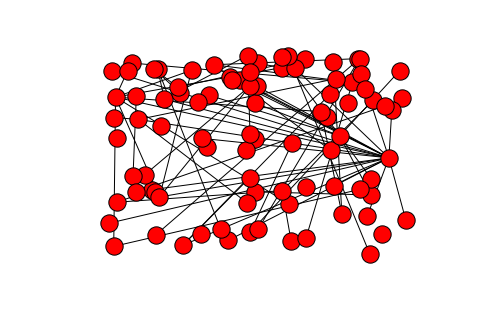

In [33]:
# ways of drawing the graph

# nx.draw(graph)
nx.draw_random(graph)
# nx.draw_circular(graph)
# nx.draw_spectral(graph)
plt.show()

### Community detection

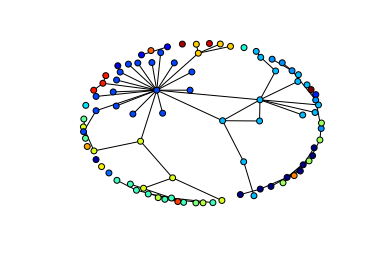

In [34]:
import networkx as nx
import matplotlib.pyplot as plt
import community
 
def detectCommunities(G):
 
    parts = community.best_partition(G)
    values = [parts.get(node) for node in G.nodes()]

    plt.axis("off")
    nx.draw_networkx(G, cmap = plt.get_cmap("jet"), node_color = values, node_size = 35, with_labels = False)
    plt.show()
    
detectCommunities(graph)

#### Analyse the number of occurences per connection

In [35]:
from collections import Counter
occurences_per_connection = Counter(edges_active)
occurences_per_connection

Counter({('04_8_1437', u'04_8_1437'): 3,
         ('06230550_IS', u'MaghrebiHD'): 1,
         ('1515Ummah', u'mustaklash'): 1,
         ('432Mryam', u'abuayisha102'): 1,
         ('AbdusMujahid149', u'AbdusMujahid149'): 1,
         ('AbuMusab_110', u'kIakishini5'): 1,
         ('AbuNaseeha_03', u'MaghrebiQM'): 1,
         ('Abu_Azzzam25', u'RamiAlLolah'): 1,
         ('Abu_Ibn_Taha', u'Baqiyah_Khilafa'): 1,
         ('Afriqqiya_252', u'Afriqqiya_252'): 4,
         ('Al_Battar_Engl', u'Al_Battar_Engl'): 1,
         ('Alwala_bara', u'RamiAlLolah'): 1,
         ('AsimAbuMerjem', u'Nidalgazaui'): 1,
         ('Bajwa47online', u'Bajwa47online'): 1,
         ('Baqiyah_Khilafa', u'Jazrawi_Joulan'): 1,
         ('Battar_English', u'Battar_English'): 1,
         ('BilalIbnRabah1', u'Nidalgazaui'): 1,
         ('DabiqsweetsMan', u'RamiAlLolah'): 1,
         ('DawlaWitness11', u'MaghrebiWM'): 1,
         ('Dieinurage308', u'Dieinurage308'): 4,
         ('EPlC24', u'MaghrebiHD'): 1,
         ('Fid

In some cases a user sends a message to his own profile. This sounds as a remarkable thing to do. 
This could explain why some nodes don't seem to have a connection when the connections are represented as a graph.

Even, in some cases a user has only one connection, which is his own profile, and sends multiple tweets to his own profile. For example: 
    
    ('04_8_1437', u'04_8_1437'): 3 
    
This could imply that either this person posts tweets to him self as a reminder, possibly a reminder of another tweet. Or multiple users are the owner of this profile and possibly collect retweets. This could still be explored in more detail.

#### Add the number of occurences per connection as an attribute to the edge

In [148]:
nx.set_edge_attributes(graph, 'occurences_per_connection_att', occurences_per_connection)
# print 'example of # of occurences between AbuMusab_110 and freelance_112: ' 
# graph['WarReporter1']['Uncle_SamCoco']['occurences_per_connection_att']

KeyError: u'Nidalgazaui'